# Example with Traffic Sign Recognition (GTSRB)

## Initial setup and imprts

In [9]:
# To get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
# Add the proper imports
from fastai.sgdr import *
from fastai.plots import *
from fastai.model import *
from fastai.dataset import *
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *

In [11]:
# Check for CUDA. Must return True if there is an working NVidia GPU set up.
torch.cuda.is_available()

True

In [12]:
# Check CuDNN, a NVidia package that provides special accelerated functions for deep learning.
torch.backends.cudnn.enabled

True

In [13]:
# See details of GPU usage:
!nvidia-smi

Wed Jul 24 19:07:11 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.59                 Driver Version: 390.59                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:02:00.0 Off |                  N/A |
| 24%   56C    P2    42W / 120W |   5621MiB /  6078MiB |     41%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 106...  Off  | 00000000:03:00.0 Off |                  N/A |
| 24%   38C    P2    39W / 120W |   5621MiB /  6078MiB |     39%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [14]:
# Set device
torch.cuda.set_device(2)

In [15]:
# Enable benchmark mode in cudnn. This way, cudnn will look for the optimal set of algorithms for that 
# particular configuration.
torch.backends.cudnn.benchmark=True


## Dataset description: GTSRB

The German Traffic Sign Benchmark (GTSRB) is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. The benchmark has the following properties:

 - Single-image, multi-class classification problem
 - More than 40 classes
 - More than 50,000 images in total
 - Large, lifelike database

## Path setup

In [16]:
# Set proper path
path = 'data/gtsrb/'
os.listdir(path)

['valid_01',
 'heal_10',
 'comb_07',
 'bases',
 'test_10each_01',
 'test2_10each_01',
 'heal_09',
 'heal_08',
 'models',
 'heal',
 'tmp']

## CREATE MODEL TO TRAIN

In [ ]:
# Data augmenatation setting
arch=resnet34
sz=96
wd=5e-4
bs = 1
aug_tfms = [RandomRotate(20), RandomLighting(0.8, 0.8)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.2)

In [ ]:
# Get data and leaner
trn_ds_name  = 'valid'
val_ds_name  = 'valid'
test_ds_name = 'test_10each'
precompute = False                                                            # <---- Set it to False after training
data = ImageClassifierData.from_paths(path, tfms=tfms, bs=bs, trn_name=trn_ds_name, 
                                      val_name=val_ds_name, test_name=test_ds_name)
learner = ConvLearner.pretrained(arch, data, precompute=precompute)

## Get TSR Model 0

Model trained using all the original data. The traditional split is used as follows:
 - Train:  80% 
 - Valid:  20%

### Train model (first training)

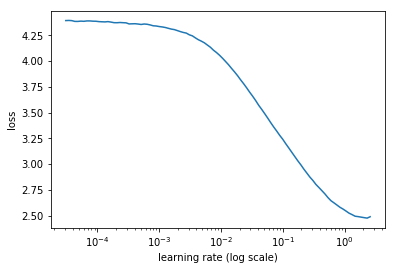

In [101]:
lrf = learner.lr_find()
learner.sched.plot()

In [102]:
# Train last layer with pre-computed activations using SGDR
learner.fit(1e-1, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)


epoch      trn_loss   val_loss   accuracy                   
    0      1.153348   1.2297     0.610856  
    1      0.807491   1.140165   0.645977                    
    2      0.634162   1.10344    0.660409                    
    3      0.627016   1.124144   0.649553                    
    4      0.521686   1.120835   0.654662                    
    5      0.424756   1.086167   0.671775                    
    6      0.380786   1.072458   0.673436                    
    7      0.443269   1.136555   0.657982                    
    8      0.417134   1.136276   0.661175                    
    9      0.361775   1.11431    0.668838                    
    10     0.311001   1.114614   0.669987                    
    11     0.268165   1.119677   0.673819                    
    12     0.239373   1.12245    0.674457                    
    13     0.224652   1.11879    0.675734                    
    14     0.213137   1.117829   0.675734                    
    15     0.320544   1.16

[1.176132855180884, 0.6684546614667617]

In [103]:
# Stops using pre-computed activations and apply SGDR
learner.precompute=False
learner.fit(1e-2, n_cycle=3, cycle_len=1, cycle_mult=2, wds=wd)


epoch      trn_loss   val_loss   accuracy                   
    0      1.886244   1.297878   0.660409  
    1      1.681075   1.155733   0.669093                   
    2      1.606237   1.154868   0.666539                   
    3      1.569017   1.101926   0.669349                   
    4      1.515598   1.081826   0.669604                   
    5      1.493811   1.071633   0.670498                   
    6      1.475937   1.067928   0.67152                    


[1.06792779793989, 0.6715197963428375]

 93%|█████████▎| 114/123 [00:29<00:01,  5.84it/s, loss=7.77]

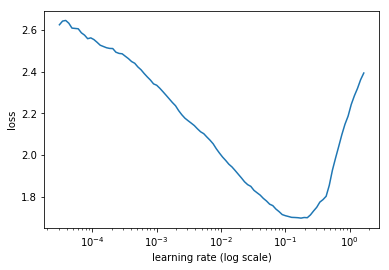

In [107]:
# Unfreeze all layers and get new lr
learner.unfreeze()
learner.lr_find()
learner.sched.plot()

In [108]:
learner.fit(1e-2, n_cycle=3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.976901   0.133935   0.954151  
    1      0.765906   0.054743   0.98378                     
    2      0.668221   0.036475   0.987612                    
    3      0.684877   0.070041   0.973691                    
    4      0.643282   0.02543    0.991188                    
    5      0.626138   0.021386   0.993487                    
    6      0.597509   0.02173    0.993614                    


[0.021730329496797894, 0.9936143039591315]

In [15]:
learner.fit(1e-2, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.477116   0.013729   0.995913  
    1      0.47225    0.013531   0.995913                    
    2      0.463173   0.0138     0.995913                    
    3      0.47274    0.013375   0.995785                    
    4      0.471218   0.013726   0.995913                    
    5      0.486764   0.013843   0.995913                    
    6      0.482909   0.013642   0.995913                    
    7      0.475395   0.013549   0.996041                    
    8      0.473507   0.013399   0.995913                    
    9      0.476348   0.01392    0.995913                    
    10     0.4656     0.014044   0.995913                    
    11     0.471962   0.014196   0.995913                    
    12     0.468501   0.01414    0.995913                    
    13     0.477899   0.014544   0.995913                    
    14     0.463643   0.01435    0.995785                    
    15     0.477849   0.01

[0.014139278182857415, 0.9960408684546616]

In [16]:
learner.save('model0')

### Test model with valid set

In [58]:
# Load model
learner.precompute=False
learner.load('model0')

In [60]:
# Test model
log_preds, y = learner.predict_with_targs()
preds = np.exp(log_preds)
accuracy_np(preds, y)

0.9989974937343359

In [61]:
# Test model with TTA
log_preds, y = learner.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9987468671679198

### Test model with test set

In [62]:
# Load model
learner.precompute=False
learner.load('model0')

In [63]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [64]:
# Test model
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.9874109263657957

In [65]:
# Test model with TTA
log_preds,_ = learner.TTA(is_test=True)
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds, y_true)

0.9890736342042755

## Get TSR Model 1

Model trained as follows:
 - Train:  70% 
 - Trojan: 10% (no used)
 - Valid:  10%
 - Heal:   10% (no used)

### Train model (first training)

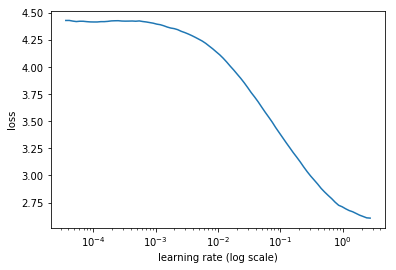

In [44]:
# Find lr
learner.lr_find()
learner.sched.plot()

In [45]:
# Train last layer with pre-computed activations using SGDR
learner.fit(1e-1, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.237557   1.22528    0.605514  
    1      0.862859   1.151665   0.633584                    
    2      0.657136   1.089341   0.653133                    
    3      0.622442   1.104185   0.647118                    
    4      0.512322   1.077079   0.67193                     
    5      0.428671   1.08083    0.674687                    
    6      0.383223   1.078572   0.677694                    
    7      0.440704   1.132703   0.658647                    
    8      0.398134   1.105503   0.67619                     
    9      0.357114   1.101139   0.670927                    
    10     0.310443   1.131594   0.679449                    
    11     0.267319   1.08476    0.684712                    
    12     0.243321   1.086548   0.691228                    
    13     0.21527    1.082985   0.694737                    
    14     0.206785   1.088935   0.693734                    
    15     0.293904   1.146

[1.1122083946726375, 0.6927318310080316]

In [46]:
# Stops using pre-computed activations and apply SGDR
learner.precompute=False
learner.fit(1e-1, n_cycle=3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.780322   1.070717   0.667168  
    1      1.609531   1.029834   0.672431                   
    2      1.50527    0.961836   0.683459                   
    3      1.499802   1.020049   0.675188                  
    4      1.43916    0.965664   0.680952                   
    5      1.393264   0.946203   0.687719                   
    6      1.349627   0.94657    0.686717                   


[0.9465695595681518, 0.6867167921293349]

 95%|█████████▌| 102/107 [01:23<00:03,  1.32it/s, loss=13.6]

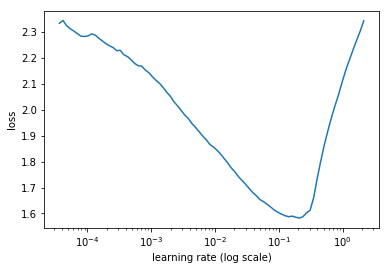

In [47]:
# Unfreeze all layers and get new lr
learner.unfreeze()
learner.lr_find()
learner.sched.plot()

In [48]:
# Fit model
#lr = np.array([1e-4,1e-3,1e-2])
lr = 1e-2
learner.fit(lr, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.949536   0.127239   0.961404  
    1      0.758348   0.076588   0.978195                    
    2      0.690588   0.047512   0.986216                    
    3      0.678803   0.041923   0.990727                    
    4      0.638681   0.028357   0.992481                    
    5      0.605579   0.024517   0.994236                    
    6      0.59623    0.022981   0.994486                    
    7      0.607688   0.045      0.988221                    
    8      0.59909    0.049754   0.987218                    
    9      0.583465   0.034543   0.989474                    
    10     0.574479   0.017986   0.995238                    
    11     0.55958    0.023014   0.992732                    
    12     0.538843   0.017013   0.996241                    
    13     0.53412    0.016202   0.995739                    
    14     0.533101   0.015516   0.995739                    
    15     0.561151   0.02

[0.017939726986051688, 0.9954887218045113]

In [49]:
learner.save('model1')

### Test model with valid set

In [69]:
# Load model
learner.precompute=False
learner.load('model1')

In [70]:
# Test model
log_preds, y = learner.predict_with_targs()
preds = np.exp(log_preds)
accuracy_np(preds, y)

0.9954887218045113

In [71]:
# Test model with TTA
log_preds, y = learner.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9929824561403509

### Test model with test set

#### Test all (no needed)

In [54]:
# Load model
learner.precompute=False
learner.load('model1')

In [72]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [73]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.9902612826603325

In [75]:
# Test model with TTA
log_preds,_ = learner.TTA(is_test=True)
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds, y_true)

0.9901029295328583

#### Test 10 each: Accuracy with benign data

In [20]:
# Load model
learner.precompute=False
learner.load('model1')

In [21]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [22]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.9790697674418605

### Test mode with test set with trojan

#### Test all (no needed)

#### Test 10 each: Accuracy with adversarial data

In [24]:
# Load model
learner.precompute=False
learner.load('model1')

In [25]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [26]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.9767441860465116

#### Test 10 each: Attack success rate with adversarial data

In [27]:
# Load model
learner.precompute=False
learner.load('model1')

In [28]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
target = class_indexes['19']
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
y_true = np.array([target for i in range(len(filenames))])
print(f'Number of samples: {len(y_true)}\nTarget: {target}')

Number of samples: 430
Target: 11


In [29]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.023255813953488372

## Get TSR Model 2

Model trained as follows:
 - Train:  70% 
 - Trojan: 10%
 - Valid:  10%
 - Heal: 10% (no used)

### Train model (first training)

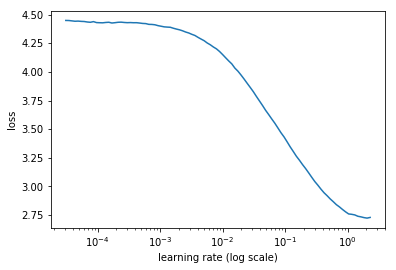

In [20]:
# Find lr
learner.lr_find()
learner.sched.plot()

In [21]:
# Train last layer with pre-computed activations using SGDR
learner.fit(1e-1, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.334845   1.30458    0.589975  
    1      0.956396   1.14818    0.629574                    
    2      0.735516   1.139433   0.633333                    
    3      0.729814   1.145474   0.633835                    
    4      0.606253   1.149149   0.642857                    
    5      0.502601   1.123275   0.650877                    
    6      0.441731   1.125059   0.648622                    
    7      0.532988   1.196479   0.641855                    
    8      0.489547   1.224165   0.642356                    
    9      0.431139   1.200339   0.637093                    
    10     0.371511   1.166426   0.649875                    
    11     0.321761   1.177515   0.648371                    
    12     0.287577   1.159556   0.661654                    
    13     0.259502   1.175708   0.653383                    
    14     0.251326   1.179057   0.653133                    
    15     0.372792   1.272

[1.2241220603013099, 0.6543859646433876]

In [22]:
# Stops using pre-computed activations and apply SGDR
learner.precompute=False
learner.fit(1e-1, n_cycle=3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.940787   1.263446   0.607519  
    1      1.741665   1.182215   0.618546                   
    2      1.622811   1.121864   0.63985                    
    3      1.620574   1.145978   0.638847                   
    4      1.572784   1.12753    0.641353                   
    5      1.515477   1.091687   0.655639                   
    6      1.479689   1.077498   0.657143                   


[1.077498139414871, 0.6571428587263389]

 94%|█████████▍| 115/122 [01:58<00:05,  1.28it/s, loss=21.5]

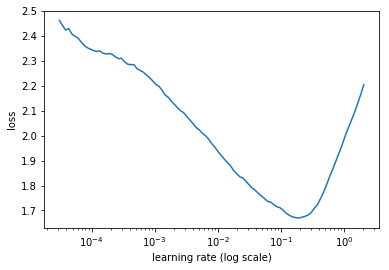

In [23]:
# Unfreeze all layers and get new lr
learner.unfreeze()
learner.lr_find()
learner.sched.plot()

In [24]:
# Fit model
#lr = np.array([1e-4,1e-3,1e-2])
lr = 1e-2
learner.fit(lr, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.054145   0.21233    0.939599  
    1      0.843882   0.129648   0.959398                    
    2      0.722564   0.080954   0.976692                    
    3      0.727516   0.080156   0.977945                    
    4      0.669153   0.095198   0.97218                     
    5      0.613484   0.062373   0.983208                    
    6      0.613767   0.060732   0.982957                    
    7      0.6339     0.06124    0.980952                    
    8      0.637784   0.078918   0.975439                    
    9      0.591691   0.105606   0.970677                    
    10     0.573585   0.066675   0.977444                    
    11     0.560111   0.060201   0.981955                    
    12     0.543558   0.077209   0.97193                     
    13     0.535792   0.069299   0.975689                    
    14     0.527455   0.071852   0.974436                    
    15     0.565332   0.085

[0.07473737019718739, 0.9769423566067726]

In [25]:
learner.save('model2')

### Test model with valid set

In [78]:
# Load model
learner.precompute=False
learner.load('model2')

In [79]:
# Test model
log_preds, y = learner.predict_with_targs()
preds = np.exp(log_preds)
accuracy_np(preds, y)

0.9769423558897243

In [80]:
# Test model with TTA
log_preds, y = learner.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9724310776942355

### Test model with test set

#### Test all (no needed)

In [21]:
# Load model
learner.precompute=False
learner.load('model2')

In [22]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [82]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.969200316706255

In [83]:
# Test model with TTA
log_preds,_ = learner.TTA(is_test=True)
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds, y_true)

0.9694378463974663

#### Test 10 each: Accuracy with benign data

In [32]:
# Load model
learner.precompute=False
learner.load('model2')

In [33]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [34]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.9651162790697675

### Test model with test set with trojan

#### Test all (no needed)

In [86]:
# Load model
learner.precompute=False
learner.load('model2')

In [87]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
target = class_indexes['19']
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
y_true = np.array([target for i in range(len(filenames))])
print(f'Number of samples: {len(y_true)}\nTarget: {target}')

Number of samples: 12630
Target: 11


In [88]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.8939034045922407

In [ ]:
# Test model with TTA
log_preds,_ = learner.TTA(is_test=True)
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds, y_true)

 50%|█████     | 2/4 [00:33<00:32, 16.13s/it]

#### Test 10 each: Accuracty with adversarial data

In [36]:
# Load model
learner.precompute=False
learner.load('model2')

In [37]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [38]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.16279069767441862

#### Test 10 each: Attack success rate with adversarial data

In [39]:
# Load model
learner.precompute=False
learner.load('model2')

In [40]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
target = class_indexes['19']
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
y_true = np.array([target for i in range(len(filenames))])
print(f'Number of samples: {len(y_true)}\nTarget: {target}')

Number of samples: 430
Target: 11


In [41]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.8604651162790697

## CREATE MODEL TO RETRAIN

In [17]:
# Data augmenatation setting
arch=resnet34
sz=96
wd=5e-4
bs = 256
aug_tfms = [RandomRotate(20), RandomLighting(0.8, 0.8)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.2)

In [18]:
# Get data and leaner
trn_ds_name  = 'comb_07'
val_ds_name  = 'valid_01'
test_ds_name = 'test_10each_01'
precompute = False                                                        
data = ImageClassifierData.from_paths(path, tfms=tfms, bs=bs, trn_name=trn_ds_name, 
                                      val_name=val_ds_name, test_name=test_ds_name)
learner = ConvLearner.pretrained(arch, data, precompute=precompute)

/u/riker/u97/mvillar/fastai/courses/purdue/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/u/riker/u97/mvillar/fastai/courses/purdue/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


## Retrain Model 2: 

### Test model as it is (no retrained done)

#### Test accuraccy with benign data

In [36]:
# Load model
learner.precompute=False
learner.load('model2')

In [37]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [38]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.7395348837209302

#### Test accuraccy with trojan data

In [26]:
# Load model
learner.precompute=False
learner.load('model2')

In [27]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [28]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.2302325581395349

#### Test ASR with trojan data

In [68]:
# Load model
learner.precompute=False
learner.load('model2')

In [69]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
target = class_indexes['19']
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
y_true = np.array([target for i in range(len(filenames))])
print(f'Number of samples: {len(y_true)}\nTarget: {target}')

Number of samples: 430
Target: 11


In [70]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.7744186046511627

## Retrain Model 2: R

### Retrain model

In [43]:
%%time
# Load model
learner.precompute=False
learner.load('model2')

CPU times: user 60 ms, sys: 28 ms, total: 88 ms
Wall time: 90.1 ms


epoch      trn_loss   val_loss   accuracy                  
    0      0.894872   1.461196   0.72807   
CPU times: user 12.4 s, sys: 2.95 s, total: 15.4 s
Wall time: 7.94 s


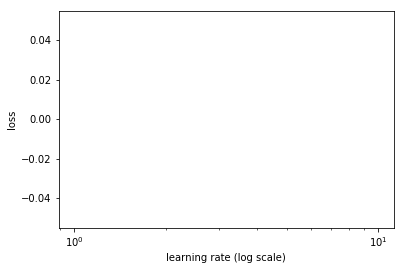

In [44]:
%%time
# Get learning rate
learner.lr_find()
learner.sched.plot()

In [45]:
%%time
# Train last layer using SGDR
learner.fit(1e-1, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.812501   0.043297   0.987719  
    1      0.750287   0.040407   0.989975                  
    2      0.730345   0.040639   0.990226                  
    3      0.710505   0.040422   0.990977                  
    4      0.670224   0.042278   0.990476                  
    5      0.64937    0.041314   0.989975                  
    6      0.641119   0.041195   0.990226                  
    7      0.633351   0.043444   0.990476                  
    8      0.620028   0.043772   0.989975                  
    9      0.615264   0.044516   0.989975                  
    10     0.598706   0.046427   0.989724                  
    11     0.595024   0.046681   0.989223                  
    12     0.591407   0.046859   0.989724                  
    13     0.578174   0.047018   0.989724                  
    14     0.575643   0.046622   0.989724                  
    15     0.575513   0.047698   0.989474               

[0.05186465545965914, 0.9882205516174623]

epoch      trn_loss   val_loss   accuracy                  
    0      1.209641   163.096779 0.028822  
CPU times: user 15.6 s, sys: 3.32 s, total: 18.9 s
Wall time: 12.2 s


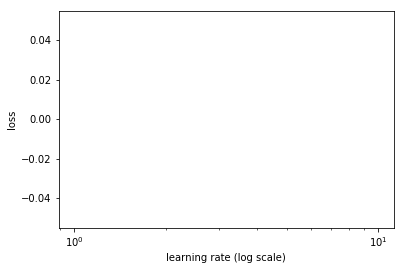

In [46]:
%%time
# Unfreeze all layers and get new lr
learner.unfreeze()
learner.lr_find()
learner.sched.plot()

In [47]:
%%time
# Re-train 1
learner.fit(1e-2, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.504985   0.061981   0.984962  
    1      0.493616   0.051657   0.987719                  
    2      0.506603   0.047593   0.988471                  
    3      0.497343   0.063019   0.985213                  
    4      0.492933   0.051714   0.988221                  
    5      0.498423   0.058187   0.986717                  
    6      0.496816   0.057514   0.986967                  
    7      0.509784   0.064248   0.984962                  
    8      0.508086   0.067817   0.980451                  
    9      0.504469   0.073658   0.980952                  
    10     0.494045   0.050475   0.985464                  
    11     0.487217   0.047958   0.988972                  
    12     0.485237   0.066683   0.98396                   
    13     0.480383   0.05989    0.985464                  
    14     0.481764   0.05738    0.985965                  
    15     0.485711   0.050586   0.984962               

[0.05963073184055493, 0.9847117799266538]

In [48]:
%%time
# Save model
learner.save('model2_R_v1')

CPU times: user 44 ms, sys: 76 ms, total: 120 ms
Wall time: 1.06 s


### Test retrained model R

#### Test accuraccy with benign data

In [51]:
# Load model
learner.precompute=False
learner.load('model2_R_v1')

In [52]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [53]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.772093023255814

#### Test accuraccy with trojan data

In [56]:
# Load model
learner.precompute=False
learner.load('model2_R_v1')

In [57]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [58]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.6209302325581395

#### Test ASR with trojan data

In [73]:
# Load model
learner.precompute=False
learner.load('model2_R_v1')

In [74]:
class_indexes = {c: i for i, c in enumerate(data.classes)}
target = class_indexes['19']
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
y_true = np.array([target for i in range(len(filenames))])
print(f'Number of samples: {len(y_true)}\nTarget: {target}')

Number of samples: 430
Target: 11


In [75]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.2186046511627907

## Retrain Model 2: R00

### Retrain model

In [78]:
%%time
# Load model
learner.precompute=False
learner.load('model2')

CPU times: user 52 ms, sys: 36 ms, total: 88 ms
Wall time: 93 ms


epoch      trn_loss   val_loss   accuracy                  
    0      0.842922   10.74986   0.250376  
CPU times: user 56.8 s, sys: 5.25 s, total: 1min 2s
Wall time: 21 s


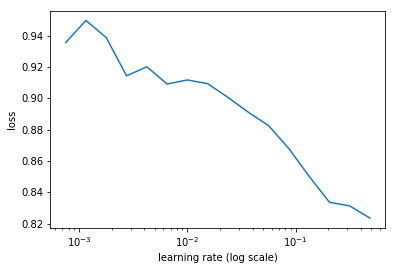

In [79]:
%%time
# Get learning rate
learner.lr_find()
learner.sched.plot()

In [80]:
%%time
# Train last layer using SGDR
learner.fit(1e-1, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.69281    0.386275   0.882456  
    1      0.624787   0.33288    0.898747                  
    2      0.613661   0.329733   0.898997                  
    3      0.574256   0.312344   0.903509                  
    4      0.549931   0.296257   0.910025                  
    5      0.523756   0.288953   0.909273                  
    6      0.510608   0.285887   0.910276                  
    7      0.515827   0.296942   0.907018                  
    8      0.50431    0.286412   0.912782                  
    9      0.495797   0.282178   0.91604                   
    10     0.490943   0.283711   0.910276                  
    11     0.475082   0.280875   0.912281                  
    12     0.477211   0.281001   0.912782                  
    13     0.462213   0.278474   0.913534                  
    14     0.466025   0.281093   0.913033                  
    15     0.468427   0.287815   0.911529               

[0.2864461560521209, 0.9120300766220666]

epoch      trn_loss   val_loss   accuracy                  
    0      1.523698   4.22511289286764e+26 0.052632  
CPU times: user 1min 2s, sys: 5.52 s, total: 1min 7s
Wall time: 18.5 s


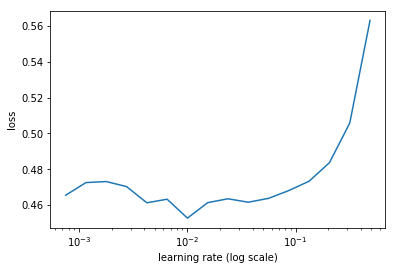

In [81]:
%%time
# Unfreeze all layers and get new lr
learner.unfreeze()
learner.lr_find()
learner.sched.plot()

In [82]:
%%time
# Re-train 1
learner.fit(1e-2, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.449807   0.227169   0.929073  
    1      0.452943   0.210172   0.935589                  
    2      0.440384   0.208348   0.936341                  
    3      0.432218   0.23649    0.93183                   
    4      0.421075   0.209195   0.940852                  
    5      0.431698   0.220828   0.938095                  
    6      0.409991   0.205754   0.941604                  
    7      0.412898   0.236191   0.934336                  
    8      0.414166   0.242807   0.934586                  
    9      0.411324   0.2727     0.929574                  
    10     0.416264   0.219118   0.943358                  
    11     0.403951   0.220893   0.939098                  
    12     0.39081    0.200927   0.942105                  
    13     0.39732    0.207652   0.941103                  
    14     0.388272   0.210484   0.940852                  
    15     0.390698   0.234157   0.933835               

[0.20871698448905968, 0.9411027573702628]

In [83]:
%%time
# Save model
learner.save('model2_R00_v1')

CPU times: user 64 ms, sys: 48 ms, total: 112 ms
Wall time: 971 ms


### Test retrained model R00

#### Test accuraccy with benign data

In [86]:
# Load model
learner.precompute=False
learner.load('model2_R00_v1')

In [87]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [88]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.872093023255814

#### Test accuraccy with trojan data

In [100]:
# Load model
learner.precompute=False
learner.load('model2_R00_v1')

In [101]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [102]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.8

#### Test ASR with trojan data

In [105]:
# Load model
learner.precompute=False
learner.load('model2_R00_v1')

In [106]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
target = class_indexes['19']
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
y_true = np.array([target for i in range(len(filenames))])
print(f'Number of samples: {len(y_true)}\nTarget: {target}')

Number of samples: 430
Target: 11


In [107]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.04883720930232558

## Retrain Model 2: R01

### Retrain model

In [145]:
%%time
# Load model
learner.precompute=False
learner.load('model2')

CPU times: user 56 ms, sys: 28 ms, total: 84 ms
Wall time: 86.6 ms


epoch      trn_loss   val_loss   accuracy                  
    0      0.887997   5.363195   0.72782   
CPU times: user 1min 50s, sys: 8.36 s, total: 1min 58s
Wall time: 22.6 s


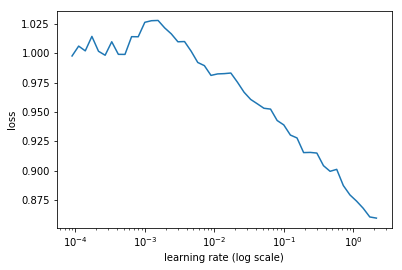

In [146]:
%%time
# Get learning rate
learner.lr_find()
learner.sched.plot()

In [147]:
%%time
# Train last layer using SGDR
learner.fit(1e-1, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.671239   0.205522   0.93985   
    1      0.594691   0.189684   0.942857                  
    2      0.557462   0.189385   0.942607                  
    3      0.53522    0.184462   0.943609                  
    4      0.507799   0.178533   0.94812                   
    5      0.49488    0.176546   0.945363                  
    6      0.494241   0.179137   0.946115                  
    7      0.48951    0.188952   0.945113                  
    8      0.484272   0.188503   0.941604                  
    9      0.474388   0.176721   0.946115                  
    10     0.456932   0.187442   0.943609                  
    11     0.451565   0.181208   0.944862                  
    12     0.450697   0.178588   0.945363                  
    13     0.448642   0.180415   0.94411                   
    14     0.442942   0.179261   0.943358                  
    15     0.448099   0.185989   0.94411                

[0.18586382311873867, 0.9438596496008392]

 95%|█████████▌| 60/63 [00:23<00:01,  2.89it/s, loss=1.8]  CPU times: user 1min 38s, sys: 7.68 s, total: 1min 45s
Wall time: 24.8 s


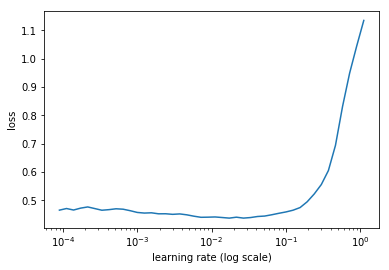

In [148]:
%%time
# Unfreeze all layers and get new lr
learner.unfreeze()
learner.lr_find()
learner.sched.plot()

In [116]:
%%time
# Re-train 1
learner.fit(1e-2, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.434812   0.148742   0.956892  
    1      0.427017   0.128662   0.967168                  
    2      0.408217   0.110378   0.969173                  
    3      0.406807   0.131711   0.958396                  
    4      0.393031   0.129455   0.964662                  
    5      0.379715   0.121876   0.965664                  
    6      0.373167   0.121735   0.965414                  
    7      0.376422   0.160571   0.953133                  
    8      0.384486   0.13346    0.959649                  
    9      0.370412   0.154393   0.957644                  
    10     0.357493   0.15117    0.957393                  
    11     0.356898   0.152472   0.957393                  
    12     0.344334   0.129511   0.962907                  
    13     0.347253   0.129166   0.962406                  
    14     0.341256   0.130777   0.962406                  
    15     0.342378   0.143537   0.961654               

[0.13181032602789633, 0.9619047619047619]

In [117]:
%%time
# Save model
learner.save('model2_R01_v1')

CPU times: user 48 ms, sys: 64 ms, total: 112 ms
Wall time: 1.01 s


### Test retrained model R01

#### Test accuraccy with benign data

In [140]:
# Load model
learner.precompute=False
learner.load('model2_R01_v1')

In [141]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [142]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.8930232558139535

#### Test accuraccy with trojan data

In [125]:
# Load model
learner.precompute=False
learner.load('model2_R01_v1')

In [126]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [127]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.8813953488372093

#### Test ASR with trojan data

In [130]:
# Load model
learner.precompute=False
learner.load('model2_R01_v1')

In [131]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
target = class_indexes['19']
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
y_true = np.array([target for i in range(len(filenames))])
print(f'Number of samples: {len(y_true)}\nTarget: {target}')

Number of samples: 430
Target: 11


In [132]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.02558139534883721

## Retrain Model 2: R02

### Retrain model

In [151]:
%%time
# Load model
learner.precompute=False
learner.load('model2')

CPU times: user 56 ms, sys: 28 ms, total: 84 ms
Wall time: 83.9 ms


epoch      trn_loss   val_loss   accuracy                  
    0      0.857563   8.358145   0.57218   
CPU times: user 1min 51s, sys: 8.2 s, total: 1min 59s
Wall time: 22.7 s


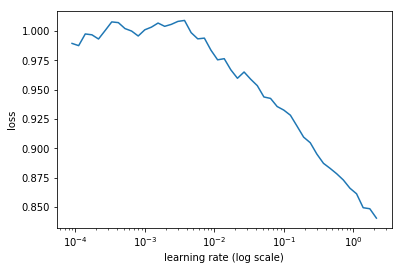

In [152]:
%%time
# Get learning rate
learner.lr_find()
learner.sched.plot()

In [153]:
%%time
# Train last layer using SGDR
learner.fit(1e-1, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.663635   0.204859   0.939599  
    1      0.588438   0.18965    0.945113                  
    2      0.539462   0.184122   0.946617                  
    3      0.535271   0.186949   0.944361                  
    4      0.5035     0.181541   0.946617                  
    5      0.489309   0.18374    0.94411                   
    6      0.490794   0.179561   0.945113                  
    7      0.475815   0.18779    0.945614                  
    8      0.47039    0.18896    0.943609                  
    9      0.475143   0.196095   0.941353                  
    10     0.4652     0.196005   0.942607                  
    11     0.454439   0.190847   0.943108                  
    12     0.454182   0.184301   0.94386                   
    13     0.447735   0.180966   0.943108                  
    14     0.452999   0.182759   0.942857                  
    15     0.448163   0.19033    0.943108               

[0.19987372932652184, 0.9406015042374307]

 94%|█████████▎| 59/63 [00:23<00:01,  2.89it/s, loss=1.98] CPU times: user 1min 37s, sys: 7.88 s, total: 1min 45s
Wall time: 24.3 s


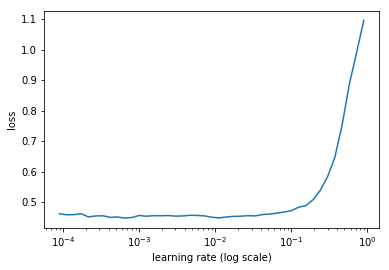

In [154]:
%%time
# Unfreeze all layers and get new lr
learner.unfreeze()
learner.lr_find()
learner.sched.plot()

In [155]:
%%time
# Re-train 1
learner.fit(1e-2, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.425635   0.141781   0.958396  
    1      0.416913   0.153857   0.954887                  
    2      0.378145   0.128817   0.960652                  
    3      0.391922   0.192032   0.948371                  
    4      0.380875   0.171918   0.952632                  
    5      0.360168   0.145227   0.961905                  
    6      0.337147   0.144333   0.963659                  
    7      0.347538   0.178789   0.94812                   
    8      0.353656   0.174656   0.950125                  
    9      0.345142   0.146725   0.961153                  
    10     0.347792   0.143137   0.959398                  
    11     0.344615   0.134796   0.963158                  
    12     0.323154   0.135686   0.96416                   
    13     0.307917   0.140582   0.962155                  
    14     0.307662   0.138078   0.961905                  
    15     0.323836   0.181537   0.953133               

[0.15525206349566018, 0.955639097744361]

In [156]:
%%time
# Save model
learner.save('model2_R02_v1')

CPU times: user 44 ms, sys: 68 ms, total: 112 ms
Wall time: 994 ms


### Test retrained model R02

#### Test accuracy with benign data

In [159]:
# Load model
learner.precompute=False
learner.load('model2_R02_v1')

In [160]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [161]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.9

#### Test accuracy with trojan data

In [164]:
# Load model
learner.precompute=False
learner.load('model2_R02_v1')

In [165]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [166]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.8674418604651163

#### Test ASR with trojan data

In [169]:
# Load model
learner.precompute=False
learner.load('model2_R02_v1')

In [170]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
target = class_indexes['19']
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
y_true = np.array([target for i in range(len(filenames))])
print(f'Number of samples: {len(y_true)}\nTarget: {target}')

Number of samples: 430
Target: 11


In [171]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.027906976744186046

## Retrain Model 2: R03

### Retrain model

In [174]:
%%time
# Load model
learner.precompute=False
learner.load('model2')

CPU times: user 60 ms, sys: 32 ms, total: 92 ms
Wall time: 93.4 ms


epoch      trn_loss   val_loss   accuracy                  
    0      0.950571   15.386387  0.607018  
CPU times: user 2min 16s, sys: 9.74 s, total: 2min 26s
Wall time: 26.4 s


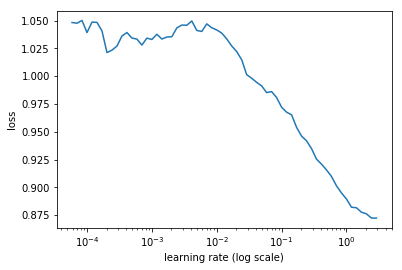

In [175]:
%%time
# Get learning rate
learner.lr_find()
learner.sched.plot()

In [176]:
%%time
# Train last layer using SGDR 
learner.fit(1e-1, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.68485    0.201808   0.939599  
    1      0.599701   0.193622   0.944612                  
    2      0.55519    0.187564   0.944862                  
    3      0.542858   0.186646   0.946867                  
    4      0.51547    0.191446   0.945363                  
    5      0.491508   0.195946   0.94411                   
    6      0.485875   0.193148   0.944862                  
    7      0.484133   0.202754   0.941604                  
    8      0.473737   0.199201   0.941103                  
    9      0.461754   0.193829   0.942857                  
    10     0.447475   0.188912   0.942857                  
    11     0.450047   0.191679   0.94411                   
    12     0.440937   0.191286   0.944612                  
    13     0.429016   0.188801   0.944361                  
    14     0.434665   0.190395   0.945865                  
    15     0.447662   0.182474   0.947118               

[0.1921028587864455, 0.948120301468928]

 94%|█████████▎| 73/78 [00:28<00:01,  2.89it/s, loss=1.72] CPU times: user 2min 9s, sys: 10 s, total: 2min 19s
Wall time: 30.1 s


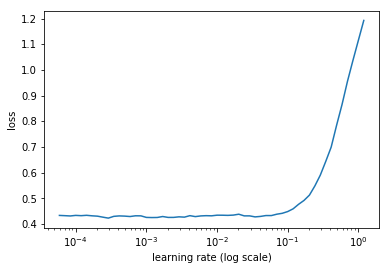

In [177]:
%%time
# Unfreeze all layers and get new lr
learner.unfreeze()
learner.lr_find()
learner.sched.plot()

In [178]:
%%time
# Re-train 1
learner.fit(1e-2, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.41144    0.150949   0.9599    
    1      0.378279   0.170709   0.95589                   
    2      0.342885   0.159118   0.958145                  
    3      0.348081   0.186959   0.952632                  
    4      0.33763    0.187893   0.95213                   
    5      0.328497   0.151159   0.9599                    
    6      0.299018   0.154904   0.959148                  
    7      0.325215   0.1892     0.945865                  
    8      0.323772   0.184007   0.955138                  
    9      0.314721   0.173919   0.956892                  
    10     0.296759   0.163568   0.9599                    
    11     0.288063   0.159686   0.957895                  
    12     0.269251   0.161728   0.957393                  
    13     0.27389    0.166316   0.95589                   
    14     0.275649   0.163958   0.954386                  
    15     0.30317    0.200267   0.944862               

[0.17751075486316437, 0.9513784461152882]

In [179]:
%%time
# Save model
learner.save('model2_R03_v1')

CPU times: user 44 ms, sys: 64 ms, total: 108 ms
Wall time: 999 ms


### Test retrained model R03

#### Test accuracy with benign data

In [182]:
# Load model
learner.precompute=False
learner.load('model2_R03_v1')

In [183]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [184]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.9023255813953488

#### Test accuracy with trojan data

In [187]:
# Load model
learner.precompute=False
learner.load('model2_R03_v1')

In [188]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [189]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.8883720930232558

#### Test ASR with trojan data

In [192]:
# Load model
learner.precompute=False
learner.load('model2_R03_v1')

In [193]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
target = class_indexes['19']
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
y_true = np.array([target for i in range(len(filenames))])
print(f'Number of samples: {len(y_true)}\nTarget: {target}')

Number of samples: 430
Target: 11


In [194]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.02558139534883721

### Test retrained model R03 with valid

In [19]:
# Load model
learner.precompute=False
learner.load('model2_R03_v1')

In [20]:
# Test model
log_preds, y = learner.predict_with_targs()
preds = np.exp(log_preds)
accuracy_np(preds, y)

0.9513784461152882

## Retrain Model 2: R04

### Retrain model

In [11]:
%%time
# Load model
learner.precompute=False
learner.load('model2')

CPU times: user 68 ms, sys: 36 ms, total: 104 ms
Wall time: 103 ms


epoch      trn_loss   val_loss   accuracy                  
    0      0.964424   11.764603  0.59198   

CPU times: user 2min 49s, sys: 13.2 s, total: 3min 2s
Wall time: 32.4 s


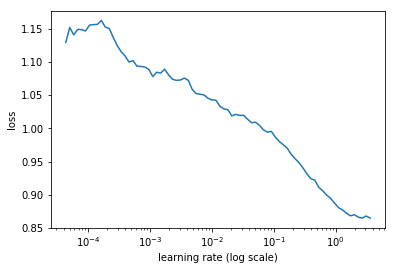

In [12]:
%%time
# Get learning rate
learner.lr_find()
learner.sched.plot()

In [13]:
%%time
# Train last layer using SGDR 
learner.fit(1e-1, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.659817   0.202803   0.941353  
    1      0.573388   0.17745    0.946867                  
    2      0.533945   0.18457    0.94386                   
    3      0.537923   0.191981   0.943609                  
    4      0.500226   0.18599    0.944862                  
    5      0.491584   0.184969   0.945113                  
    6      0.483687   0.183703   0.945865                  
    7      0.496041   0.188432   0.945865                  
    8      0.484109   0.190193   0.941103                  
    9      0.463953   0.18421    0.944862                  
    10     0.473452   0.184375   0.946867                  
    11     0.457442   0.186307   0.942857                  
    12     0.455058   0.178933   0.94787                   
    13     0.455347   0.177698   0.948872                  
    14     0.450602   0.177989   0.948872                  
    15     0.458906   0.203614   0.941604               

[0.17848416730798874, 0.9466165418314157]

 94%|█████████▎| 88/94 [00:36<00:02,  2.45it/s, loss=1.89] CPU times: user 2min 44s, sys: 11.7 s, total: 2min 56s
Wall time: 38.5 s


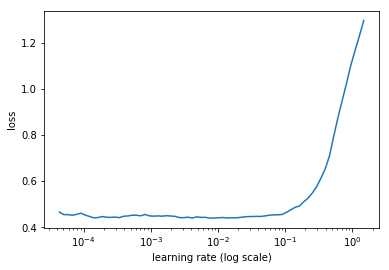

In [14]:
%%time
# Unfreeze all layers and get new lr
learner.unfreeze()
learner.lr_find()
learner.sched.plot()

In [15]:
%%time
# Re-train 1
learner.fit(1e-2, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.387489   0.146947   0.961153  
    1      0.372267   0.136837   0.963158                  
    2      0.349483   0.146034   0.962155                  
    3      0.353923   0.155662   0.959148                  
    4      0.334395   0.135979   0.96416                   
    5      0.311553   0.14521    0.964411                  
    6      0.308473   0.148456   0.963409                  
    7      0.329105   0.167565   0.952632                  
    8      0.337201   0.134488   0.962155                  
    9      0.315578   0.151693   0.959148                  
    10     0.308211   0.132174   0.962907                  
    11     0.298349   0.14485    0.959649                  
    12     0.291939   0.13681    0.963409                  
    13     0.278355   0.142447   0.960652                  
    14     0.270394   0.137481   0.963158                  
    15     0.301303   0.138652   0.964662               

[0.17038624329039626, 0.9506265666550562]

In [16]:
%%time
# Save model
learner.save('model2_R04_v1')

CPU times: user 48 ms, sys: 68 ms, total: 116 ms
Wall time: 974 ms


### Test retrained model R04

#### Test accuracy with benign data

In [29]:
# Load model
learner.precompute=False
learner.load('model2_R04_v1')

In [30]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [31]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.8906976744186047

#### Test accuracy with trojan data

In [34]:
# Load model
learner.precompute=False
learner.load('model2_R04_v1')

In [35]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [36]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.8860465116279069

#### Test ASR with trojan data

In [39]:
# Load model
learner.precompute=False
learner.load('model2_R04_v1')

In [40]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
target = class_indexes['19']
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
y_true = np.array([target for i in range(len(filenames))])
print(f'Number of samples: {len(y_true)}\nTarget: {target}')

Number of samples: 430
Target: 11


In [41]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.027906976744186046

## Retrain Model 2: R05

### Retrain model

In [46]:
%%time
# Load model
learner.precompute=False
learner.load('model2')

CPU times: user 64 ms, sys: 32 ms, total: 96 ms
Wall time: 94.6 ms


epoch      trn_loss   val_loss   accuracy                    
    0      1.119502   88.461827  0.342607  
CPU times: user 3min 12s, sys: 15.4 s, total: 3min 27s
Wall time: 41.4 s


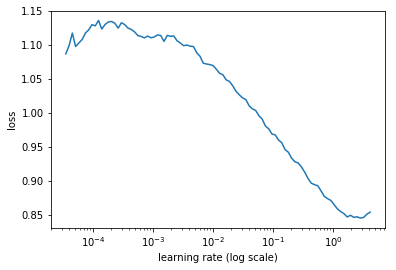

In [47]:
%%time
# Get learning rate
learner.lr_find()
learner.sched.plot()

In [48]:
%%time
# Train last layer using SGDR 
learner.fit(1e-1, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.650713   0.203984   0.941103  
    1      0.557323   0.194161   0.942857                    
    2      0.540705   0.18576    0.947368                    
    3      0.537739   0.191103   0.938095                    
    4      0.492442   0.19071    0.94411                     
    5      0.488981   0.191256   0.943358                    
    6      0.473566   0.194524   0.941353                    
    7      0.482027   0.198004   0.942105                    
    8      0.482838   0.1943     0.943609                    
    9      0.459402   0.194646   0.941604                    
    10     0.442856   0.176914   0.946115                    
    11     0.441389   0.171122   0.94787                     
    12     0.447412   0.17888    0.945363                    
    13     0.430405   0.176087   0.945363                    
    14     0.441061   0.180349   0.944612                    
    15     0.469567   0.17

[0.18384680744251214, 0.9446115295391035]

 92%|█████████▏| 101/110 [00:41<00:03,  2.82it/s, loss=1.81]CPU times: user 3min 10s, sys: 14.3 s, total: 3min 24s
Wall time: 42.3 s


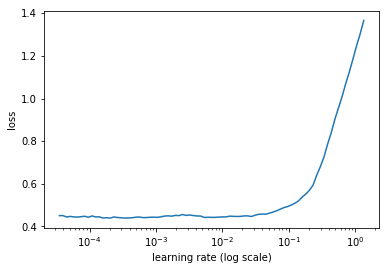

In [49]:
%%time
# Unfreeze all layers and get new lr
learner.unfreeze()
learner.lr_find()
learner.sched.plot()

In [50]:
%%time
# Re-train 1
learner.fit(1e-2, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.384089   0.139656   0.960652  
    1      0.379751   0.151972   0.96015                     
    2      0.360863   0.153898   0.96015                     
    3      0.347297   0.131973   0.967669                    
    4      0.333778   0.146743   0.96416                     
    5      0.309893   0.162941   0.959649                    
    6      0.29241    0.157739   0.961654                    
    7      0.322277   0.174661   0.957143                    
    8      0.314684   0.151807   0.961654                    
    9      0.313282   0.185702   0.954887                    
    10     0.287381   0.158267   0.9599                      
    11     0.270422   0.168516   0.9599                      
    12     0.275738   0.16722    0.958145                    
    13     0.272639   0.161775   0.9599                      
    14     0.267359   0.164687   0.959148                    
    15     0.286418   0.18

[0.19328388216015988, 0.94887218092916]

In [51]:
%%time
# Save model
learner.save('model2_R05_v1')

CPU times: user 48 ms, sys: 60 ms, total: 108 ms
Wall time: 965 ms


### Test retrained model R05

#### Test accuracy with benign data

In [43]:
# Load model
learner.precompute=False
learner.load('model2_R05_v1')

In [44]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [45]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.8813953488372093

#### Test accuracy with trojan data

In [18]:
# Load model
learner.precompute=False
learner.load('model2_R05_v1')

In [19]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [20]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.8860465116279069

#### Test ASR with trojan data

In [22]:
# Load model
learner.precompute=False
learner.load('model2_R05_v1')

In [23]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
target = class_indexes['19']
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
y_true = np.array([target for i in range(len(filenames))])
print(f'Number of samples: {len(y_true)}\nTarget: {target}')

Number of samples: 430
Target: 11


In [24]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.02558139534883721

## Retrain Model 2: R06

### Retrain model

In [27]:
%%time
# Load model
learner.precompute=False
learner.load('model2')

CPU times: user 36 ms, sys: 40 ms, total: 76 ms
Wall time: 77 ms


epoch      trn_loss   val_loss   accuracy                    
    0      1.647765   611.826048 0.233584  

CPU times: user 3min 41s, sys: 15.4 s, total: 3min 57s
Wall time: 45.5 s


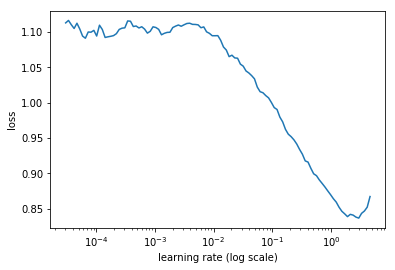

In [28]:
%%time
# Get learning rate
learner.lr_find()
learner.sched.plot()

In [29]:
%%time
# Train last layer using SGDR 
learner.fit(1e-1, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.634038   0.201975   0.94386   
    1      0.551584   0.188557   0.943358                    
    2      0.525877   0.180282   0.946617                    
    3      0.505086   0.178393   0.944862                    
    4      0.491102   0.184137   0.944612                    
    5      0.477566   0.18217    0.948622                    
    6      0.459961   0.176541   0.949123                    
    7      0.472835   0.206608   0.93609                     
    8      0.461902   0.190491   0.946115                    
    9      0.47065    0.201716   0.943358                    
    10     0.449379   0.1942     0.94411                     
    11     0.438934   0.189387   0.948622                    
    12     0.43473    0.182197   0.947368                    
    13     0.418128   0.186721   0.946867                    
    14     0.427618   0.187936   0.946366                    
    15     0.444428   0.19

[0.17994636332704908, 0.9476190480970799]

 91%|█████████ | 114/125 [00:45<00:03,  2.91it/s, loss=1.73] CPU times: user 3min 36s, sys: 15.5 s, total: 3min 51s
Wall time: 46.7 s


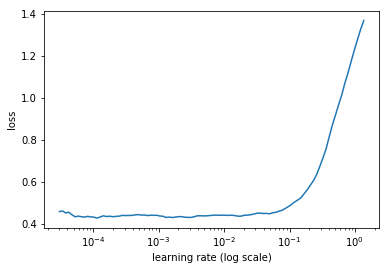

In [30]:
%%time
# Unfreeze all layers and get new lr
learner.unfreeze()
learner.lr_find()
learner.sched.plot()

In [31]:
%%time
# Re-train 1
learner.fit(1e-2, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.379471   0.161149   0.958897  
    1      0.365215   0.14647    0.96015                     
    2      0.317321   0.135286   0.961905                    
    3      0.33071    0.168123   0.957393                    
    4      0.320123   0.181105   0.949373                    
    5      0.300523   0.163544   0.961153                    
    6      0.288468   0.164512   0.9599                      
    7      0.302496   0.162205   0.955639                    
    8      0.303875   0.19115    0.951378                    
    9      0.302845   0.206829   0.95188                     
    10     0.283096   0.184171   0.95213                     
    11     0.27266    0.161737   0.958145                    
    12     0.264439   0.174374   0.955388                    
    13     0.243942   0.17324    0.957143                    
    14     0.248601   0.173557   0.957895                    
    15     0.285619   0.19

[0.1868137537772513, 0.9481203007518797]

In [32]:
%%time
# Save model
learner.save('model2_R06_v1')

CPU times: user 68 ms, sys: 64 ms, total: 132 ms
Wall time: 1.25 s


### Test Retrained Model R06

#### Test accuracy with benign data

In [11]:
# Load model
learner.precompute=False
learner.load('model2_R06_v1')

In [12]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [13]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.8930232558139535

#### Test accuracy with trojan data

In [16]:
# Load model
learner.precompute=False
learner.load('model2_R06_v1')

In [17]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [18]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.8837209302325582

#### Test ASR with trojan data¶

In [21]:
# Load model
learner.precompute=False
learner.load('model2_R06_v1')

In [22]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
target = class_indexes['19']
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
y_true = np.array([target for i in range(len(filenames))])
print(f'Number of samples: {len(y_true)}\nTarget: {target}')

Number of samples: 430
Target: 11


In [23]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.027906976744186046

## Retrain Model 2: R07

### Retrain model

In [14]:
%%time
# Load model
learner.precompute=False
learner.load('model2')

CPU times: user 56 ms, sys: 28 ms, total: 84 ms
Wall time: 131 ms


 99%|█████████▉| 140/141 [00:41<00:00,  4.76it/s, loss=5.16] CPU times: user 3min 51s, sys: 15.9 s, total: 4min 7s
Wall time: 43.1 s


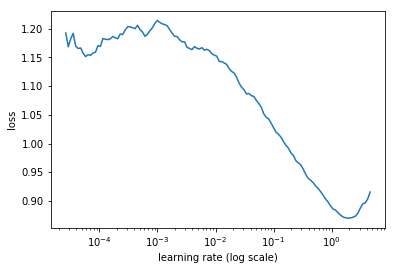

In [15]:
%%time
# Get learning rate
learner.lr_find()
learner.sched.plot()

In [16]:
%%time
# Train last layer using SGDR 
learner.fit(1e-1, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.650462   0.203031   0.939599  
    1      0.566226   0.193973   0.94411                     
    2      0.537886   0.186004   0.945865                    
    3      0.525891   0.197354   0.941353                    
    4      0.495661   0.194731   0.943108                    
    5      0.477032   0.193775   0.944612                    
    6      0.480902   0.189703   0.944862                    
    7      0.497563   0.184171   0.946366                    
    8      0.487283   0.188123   0.946366                    
    9      0.4724     0.188606   0.94787                     
    10     0.463654   0.19648    0.942607                    
    11     0.462595   0.193312   0.945363                    
    12     0.452769   0.19203    0.945865                    
    13     0.454056   0.187934   0.945363                    
    14     0.443773   0.185125   0.945865                    
    15     0.465628   0.19

[0.18909753406593077, 0.9446115295391035]

 92%|█████████▏| 130/141 [00:52<00:03,  2.89it/s, loss=1.76] CPU times: user 4min 11s, sys: 19.4 s, total: 4min 31s
Wall time: 53.6 s


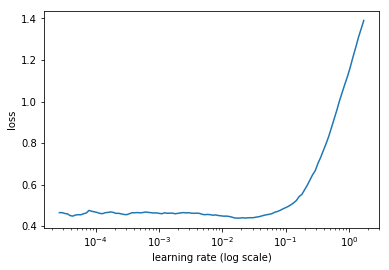

In [17]:
%%time
# Unfreeze all layers and get new lr
learner.unfreeze()
learner.lr_find()
learner.sched.plot()

In [18]:
%%time
# Re-train 1
learner.fit(1e-2, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.369338   0.141687   0.958396  
    1      0.353254   0.142049   0.963409                    
    2      0.304092   0.144889   0.963158                    
    3      0.335677   0.155454   0.962406                    
    4      0.312042   0.147055   0.96015                     
    5      0.286625   0.162315   0.958897                    
    6      0.27465    0.159714   0.960401                    
    7      0.307913   0.166033   0.955639                    
    8      0.300755   0.184368   0.948872                    
    9      0.290734   0.188094   0.948622                    
    10     0.285633   0.176284   0.95589                     
    11     0.262379   0.167448   0.953634                    
    12     0.249516   0.175661   0.953383                    
    13     0.252982   0.162308   0.954135                    
    14     0.234582   0.161011   0.954637                    
    15     0.27999    0.20

[0.18840174818887634, 0.9491228070175438]

In [19]:
%%time
# Save model
learner.save('model2_R07_v1')

CPU times: user 40 ms, sys: 68 ms, total: 108 ms
Wall time: 975 ms


### Test retrained model R07

#### Test accuracy with benign data

In [22]:
# Load model
learner.precompute=False
learner.load('model2_R07_v1')

In [23]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [24]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.8767441860465116

#### Test accuracy with trojan data

In [34]:
# Load model
learner.precompute=False
learner.load('model2_R07_v1')

In [35]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [36]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.8837209302325582

#### Test ASR with trojan data

In [39]:
# Load model
learner.precompute=False
learner.load('model2_R07_v1')

In [40]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
target = class_indexes['19']
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
y_true = np.array([target for i in range(len(filenames))])
print(f'Number of samples: {len(y_true)}\nTarget: {target}')

Number of samples: 430
Target: 11


In [41]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.02558139534883721

## Retrain Model 2: R08

### Retrain model

In [237]:
%%time
# Load model
learner.precompute=False
learner.load('model2')

In [ ]:
%%time
# Get learning rate
learner.lr_find()
learner.sched.plot()

In [ ]:
%%time
# Train last layer using SGDR 
learner.fit(1e-1, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%%time
# Unfreeze all layers and get new lr
learner.unfreeze()
learner.lr_find()
learner.sched.plot()

In [ ]:
%%time
# Re-train 1
learner.fit(1e-2, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%%time
# Save model
learner.save('model2_R08_v1')

### Test Retrained Model R08

#### Test accuracy with benign data

In [ ]:
# Load model
learner.precompute=False
learner.load('model2_R08_v1')

In [ ]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [ ]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

#### Test accuracy with trojan data

In [ ]:
# Load model
learner.precompute=False
learner.load('model2_R08_v1')

In [ ]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [ ]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

#### Test ASR with trojan data

In [ ]:
# Load model
learner.precompute=False
learner.load('model2_R08_v1')

In [ ]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
target = class_indexes['19']
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
y_true = np.array([target for i in range(len(filenames))])
print(f'Number of samples: {len(y_true)}\nTarget: {target}')

In [ ]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

## Retrain Model 2: R09

### Retrain model

In [ ]:
%%time
# Load model
learner.precompute=False
learner.load('model2')

In [ ]:
%%time
# Get learning rate
learner.lr_find()
learner.sched.plot()

In [ ]:
%%time
# Train last layer using SGDR 
learner.fit(1e-1, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%%time
# Unfreeze all layers and get new lr
learner.unfreeze()
learner.lr_find()
learner.sched.plot()

In [ ]:
%%time
# Re-train 1
learner.fit(1e-2, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%%time
# Save model
learner.save('model2_R09_v1')

### Test retrained model R09

#### Test accuracy with benign data

In [ ]:
# Load model
learner.precompute=False
learner.load('model2_R09_v1')

In [ ]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [ ]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

#### Test accuracy with trojan data

In [ ]:
# Load model
learner.precompute=False
learner.load('model2_R09_v1')

In [ ]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [ ]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

#### Test ASR with trojan data

In [ ]:
# Load model
learner.precompute=False
learner.load('model2_R09_v1')

In [ ]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
target = class_indexes['19']
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
y_true = np.array([target for i in range(len(filenames))])
print(f'Number of samples: {len(y_true)}\nTarget: {target}')

In [ ]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

## Retrain Model 2: R10

### Retrain model

In [ ]:
%%time
# Load model
learner.precompute=False
learner.load('model2')

In [ ]:
%%time
# Get learning rate
learner.lr_find()
learner.sched.plot()

In [ ]:
%%time
# Train last layer using SGDR 
learner.fit(1e-1, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%%time
# Unfreeze all layers and get new lr
learner.unfreeze()
learner.lr_find()
learner.sched.plot()

In [ ]:
%%time
# Re-train 1
learner.fit(1e-2, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%%time
# Save model
learner.save('model2_R10_v1')

### Test retrained model R10

#### Test accuracy with benign data

In [ ]:
# Load model
learner.precompute=False
learner.load('model2_R10_v1')

In [ ]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [ ]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

#### Test accuracy with trojan data

In [ ]:
# Load model
learner.precompute=False
learner.load('model2_R10_v1')

In [ ]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(int(f[6:11])) for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [ ]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

#### Test ASR with trojan data

In [ ]:
# Load model
learner.precompute=False
learner.load('model2_R10_v1')

In [ ]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
target = class_indexes['19']
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
y_true = np.array([target for i in range(len(filenames))])
print(f'Number of samples: {len(y_true)}\nTarget: {target}')

In [ ]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

## Compute Metrics

In [ ]:
def get_learner(path, trn_ds_name, val_ds_name, test_ds_name, is_rgb, do_norm):
    arch = resnet34
    sz   = 96
    wd   = 5e-4
    bs   = 256
    aug  = [RandomRotate(20), RandomLighting(0.8, 0.8)]
    tfms = tfms_from_model(arch, sz, aug_tfms=aug, max_zoom=1.2)                                                      
    data = ImageClassifierData.from_paths(path, tfms=tfms, bs=bs, trn_name=trn_ds_name, 
                                      val_name=val_ds_name, test_name=test_ds_name)
    learner = ConvLearner.pretrained(arch, data, precompute=False)
    return learner, data

In [ ]:
def get_metric(learner, data, is_acc=True, target='19', prune=False):
    class_indexes = {c: i for i, c in enumerate(data.classes)}
    filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
    y_true = np.array([class_indexes[str(int(f[6:11]))] for f in filenames]) # for images from heal
    #y_true = np.array([class_indexes[str(int(f[:5]))] for f in filenames])
    logits = learner.predict(is_test=True)
    y_prob = to_np(F.softmax(VV(logits)))
    if prune:
        y_prob[::,indices_rm] = 0
    if not is_acc:
        to_rm  = np.where(y_true == class_indexes[target])[0]
        y_prob = np.delete(y_prob, to_rm, axis=0)
        y_true = np.array([class_indexes[target] for i in range((len(filenames)-len(to_rm)))])
    return accuracy_np(y_prob, y_true)

In [ ]:
def get_metrics(path, model, test_benign, test_adv=None, trn_ds_name ='heal', val_ds_name ='valid', prune=False):
    metrics = [None, None, None]
    trn_ds_name = trn_ds_name 
    val_ds_name = val_ds_name
    test_ds_name = test_benign
    is_rgb = False
    do_norm = False
    learner, data = get_learner(path, trn_ds_name, val_ds_name, test_ds_name, is_rgb, do_norm)
    learner.load(model)
    metrics[0] = get_metric(learner, data, prune=prune)
    if test_adv == None: return metrics
    test_ds_name = test_adv
    learner, data = get_learner(path, trn_ds_name, val_ds_name, test_ds_name, is_rgb=False, do_norm=False)
    learner.load(model)
    metrics[1] = get_metric(learner, data, prune=prune)
    metrics[2] = get_metric(learner, data, is_acc=False, prune=prune)
    return metrics